# Imports and file loading

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline
import imageio
from scipy.ndimage.interpolation import rotate
from math import cos, sin
import time
import random
import string
pi=3.14159

In [2]:
file_directory='/home/preston/Desktop/Science/Research/video/'
file_name='microbeads_2.mp4'
ffmpeg_bin='/home/preston/ffmpeg-3.0.2-64bit-static/ffmpeg'

# Clustering

In [3]:
class cluster:
    def __init__(self, frame, pixels):
        
        identity=random.choice(string.letters)
        
        self._trajectory=np.zeros((0,7))
        
        t=frame
        
        x_0=pixels[:,1].min()
        x_1=pixels[:,1].max()
        y_0=pixels[:,0].min()
        y_1=pixels[:,0].max()
        
        x = int((x_1+x_0)/2.)
        y = int((y_1+y_0)/2.)
        
        vx=0
        vy=0
            
        w = x_1-x_0
        h = y_1-y_0
        
        
        
        
        self._pixels=[pixels]
        self._identity=identity
        self._t=[t]
        self._x=[x]
        self._y=[y]
        self._vx=[vx]
        self._vy=[vy]
        self._w=[w]
        self._h=[h]
        self._x_pred=self._x[-1]
        self._y_pred=self._y[-1]
        
        
        
    
    def update_predicted_position(self, frame):        
        self._x_pred=self._x[-1]+self._vx[-1]*(frame-self._t[-1])
        self._y_pred=self._y[-1]+self._vy[-1]*(frame-self._t[-1])
        
        return
    
    def update_trajectory(self, cluster):       
        self._pixels.append(cluster._pixels)
        self._t.append(cluster._t[-1])
        self._x.append(cluster._x[-1])
        self._y.append(cluster._y[-1])
        
        self._vx.append(1.*(self._x[-1]-self._x[-2])/(self._t[-1]-self._t[-2]))
        self._vy.append(1.*(self._y[-1]-self._y[-2])/(self._t[-1]-self._t[-2]))
        
        self._w.append(cluster._w[-1])
        self._h.append(cluster._h[-1])
        
        return

In [4]:
def get_clusters(negative_image, frame, cluster_threshold=5):
    cluster_list=[]
    pixel_check_array=np.ones((negative_image.shape[0], negative_image.shape[1]))
    for i in range(pixel_check_array.shape[0]):
        for j in range(pixel_check_array.shape[1]):
            if pixel_check_array[i,j]==1:
                if negative_image[i,j] >= threshold_difference:
                    cluster_pixels, pixel_check_array=add_pixel_to_cluster\
                    (negative_image, pixel_check_array, i, j, threshold_difference)
                    
                    if cluster_pixels.shape[0]>cluster_threshold:
                        new_cluster=cluster(frame, cluster_pixels)
                        cluster_list.append(new_cluster)
    
    return cluster_list

In [5]:
def add_pixel_to_cluster(image, pixel_check_array, i, j, threshold, cluster_pixels=np.empty((0,2), dtype=int), direction='center'):
    
    cluster_pixels=np.vstack((cluster_pixels,[i,j]))
    pixel_check_array[i,j]=0
    
    # Center (first point)
    if direction == 'center':
        pixel_check_array[i,j]=0
        
    # Right
    if direction != 'right' and j != image.shape[1] -1 and pixel_check_array[i,j+1] == 1:
        if image[i,j+1]>=threshold:
            cluster_pixels, pixel_check_array=add_pixel_to_cluster(image, pixel_check_array, i, j+1, threshold, cluster_pixels, 'left')

    # Below
    if direction != 'below' and i != image.shape[0] - 1 and pixel_check_array[i+1,j] == 1:
        if image[i+1,j]>=threshold:
            cluster_pixels, pixel_check_array=add_pixel_to_cluster(image, pixel_check_array, i+1, j, threshold, cluster_pixels, 'above')   
        
    # Left
    if direction != 'left' and j != 0 and pixel_check_array[i,j-1] == 1:
        if image[i,j-1]>=threshold:
            cluster_pixels, pixel_check_array=add_pixel_to_cluster(image, pixel_check_array, i, j-1, threshold, cluster_pixels, 'right')

    # Above
    if direction != 'above' and i != 0 and pixel_check_array[i-1,j] == 1:
        if image[i-1,j]>=threshold:
            cluster_pixels, pixel_check_array=add_pixel_to_cluster(image, pixel_check_array, i-1, j, threshold, cluster_pixels, 'below')

    return cluster_pixels, pixel_check_array

In [6]:
a=np.array([[1,2,3],[4,5,6],[7,8,9]])
print a
print a[[1]+[2],2]

[[1 2 3]
 [4 5 6]
 [7 8 9]]
[6 9]


In [7]:
x_thresh=500
d_thresh=10

In [8]:
def match_clusters(currently_tracking, just_tracked, previously_tracked, frame):
    
    new_currently_tracking=[]
    
    # Update currently_tracking particles' predicted positions
    for j in range(len(currently_tracking)):
        currently_tracking[j].update_predicted_position(frame)
    
    # Create, fill distance matrix
    distance_matrix=np.zeros((len(just_tracked)+1, len(currently_tracking)+1))
    

    for i in range(distance_matrix.shape[0]):
        distance_matrix[i,0]=i-1
    for j in range(distance_matrix.shape[1]):
        distance_matrix[0,j]=j-1
    
    for i in range(1,len(just_tracked)+1): # just_tracked
        for j in range(1,len(currently_tracking)+1): # currently_tracking
            xi=just_tracked[i-1]._x[-1]
            yi=just_tracked[i-1]._y[-1]
            xj=currently_tracking[j-1]._x_pred
            yj=currently_tracking[j-1]._y_pred
            distance_matrix[i,j]=((xi-xj)**2.+(yi-yj)**2.)**.5
            
            
    # Match columns to row
    check_rows=[i for i in range(0,len(just_tracked))]
    for j in range(len(currently_tracking)):
        # Get index of row with minimum distance
        if check_rows != []:# > 1:
            temp_min_row=np.argmin(distance_matrix[[row+1 for row in check_rows], j+1],0)
            min_row=int(distance_matrix[[row+1 for row in check_rows],[0]][temp_min_row])
            
            if currently_tracking[j]._x_pred > x_thresh and distance_matrix[min_row+1, j+1] >= d_thresh:
                min_row = None
            
        else:
            min_row=None
        
        # Check to see if point still good (i.e., if the minimum makes sense)
        
            
        
        
        
        
        # Correct match found
        if min_row != None:
            # Remove row from check list
            check_rows=[row for row in check_rows if row != min_row]
        
            # Update the particle that is being tracked with the matched particle
            currently_tracking[j].update_trajectory(just_tracked[min_row])
            
            # Add the particle to new_currently_tracking list
            new_currently_tracking.append(currently_tracking[j])
            
        # No match found
        else:
            previously_tracked.append(currently_tracking[j])
            
        
    # Add rows that did not match to new_currently_tracking
    for row in check_rows:
        new_currently_tracking.append(just_tracked[row])
        
    #print distance_matrix
        
    return new_currently_tracking

# Open video connection

In [9]:
vid = imageio.get_reader(file_directory+file_name,  'ffmpeg')
num_frames=vid._meta['nframes']
print num_frames

16224


# Image processing

In [10]:
def preprocess_image(image):
    ystart=50
    yend=225
    xstart=150
    xend=350
    image=rotate(image[ystart:yend, xstart:xend,:], theta, axes=(1,0), reshape=False)
    image=image[40:130, 25:180,:]
    return image

In [11]:
def get_negative_image(image, templage_image):
    negative_image=np.empty((image.shape[0], image.shape[1]), dtype=int)
    for i in range(negative_image.shape[0]):
        for j in range(negative_image.shape[1]):
            negative_image[i,j]=abs(int(image[i,j,0])-int(template_image[i,j,0]))
    return negative_image

In [12]:
def highlight_cluster_pixels(image, cluster_pixels):
    for i in range(cluster_pixels.shape[0]):
        x=cluster_pixels[i,0]
        y=cluster_pixels[i,1]
        image[x,y,0]=image[x,y,0]/10.
        image[x,y,1]=image[x,y,1]*2.
        image[x,y,2]=image[x,y,2]/10.
    return image

# Define template image

In [13]:
def get_pore_coordinates(x, y):
    new_x=(x-xp)*pore_length/pore_plength
    new_y=(y-yp)*pore_width/pore_pwidth
    return new_x, new_y

In [14]:
theta=-3.35
buff=25

pore_pwidth=20.
pore_length=125.
pore_width=25.
pore_plength=107.

xp=25
yp=43

In [15]:
template_frame=0
template_image=vid.get_data(template_frame)
#template_image=preprocess_image(template_image)

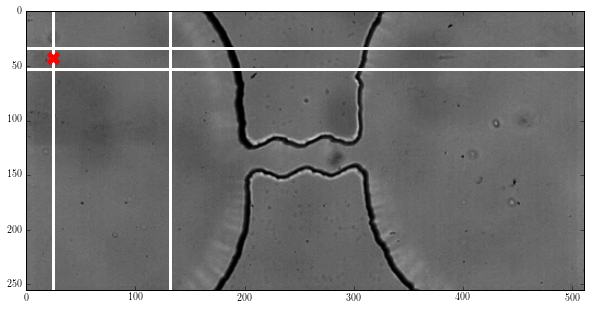

In [16]:
fig=plt.figure(figsize=(10,6))
plt.imshow(template_image)
plt.scatter(xp,yp, s=100, zorder=10, marker='x', c=(1.,0.,0.), lw=5)
plt.plot([xp,xp],[0,1000],lw=3,c=(1.,1.,1.))
plt.plot([xp+pore_plength,xp+pore_plength],[0,1000],lw=3,c=(1.,1.,1.))
plt.plot([0,1000],[yp+pore_pwidth/2,yp+pore_pwidth/2],lw=3,c=(1.,1.,1.))
plt.plot([0,1000],[yp-pore_pwidth/2,yp-pore_pwidth/2],lw=3,c=(1.,1.,1.))

plt.xlim(0,template_image.shape[1]-1)
plt.ylim(template_image.shape[0]-1,0)
plt.show()

# Particle tracking

In [17]:
previously_tracked=[]
currently_tracking=[]
particle_frames=[]

#################
start=time.time()
#################

# Begin loop
start_frame=0
end_frame=num_frames
frame_skip=1
threshold_difference=30
for frame in np.arange(start_frame,end_frame,frame_skip):
    
    if frame%100==0:
        print frame
    
    # Open, preprocess image data
    image=vid.get_data(frame)
    #image=preprocess_image(image)
    negative_image=get_negative_image(image, template_image)
    
    # Get just tracked clusters
    just_tracked = get_clusters(negative_image, frame)
    
    # Match currently_tracking clusters to just_tracked clusters, and update clusters with new positions, velocities
    currently_tracking = match_clusters(currently_tracking, just_tracked, previously_tracked, frame)
    
    # Plot
#    if len(currently_tracking)>0:
#        particle_frames.append(frame)

#        for j in range(len(currently_tracking)):
            
            #print 'frame:', frame, 'num clusters:', len(currently_tracking)

            #image=highlight_cluster_pixels(image,currently_tracking[j]._pixels)
            #plt.scatter(currently_tracking[j]._x_pred, currently_tracking[j]._y_pred, marker='x', c=(1.,0,0), lw=3)
            #plt.text(currently_tracking[j]._x[-1],currently_tracking[j]._y[-1],currently_tracking[j]._identity, size=20, color=(1.,0,0))
            
        #plt.imshow(image)
        #plt.show()
    
###############
end=time.time()
print 'time elapsed = ', end-start
###############

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
time elapsed =  4361.75986886


# Plot trajectories

In [18]:
print len(previously_tracked)

10


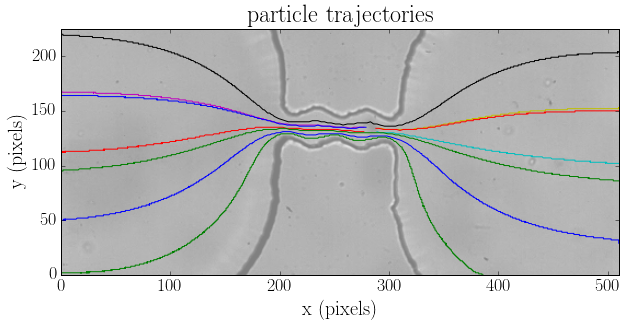

In [19]:
fig=plt.figure(figsize=(10,8))
for cluster in previously_tracked:
    plt.plot(cluster._x, cluster._y, label=cluster._identity)

plt.title('particle trajectories', size = 24)

plt.tick_params(labelsize=18)
plt.xlabel('x (pixels)', size=20)
plt.ylabel('y (pixels)', size=20)
plt.imshow(template_image, alpha=0.5)
plt.xlim(0,510)
plt.ylim(0,225)
#plt.legend()
plt.savefig('./particle_trajectories.png', dpi=300)
plt.show()

# Plot w, h, A vs position

In [ ]:
for i in range(len())

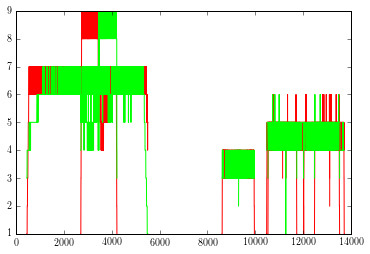

In [23]:
for i in range(len(previously_tracked)):
    plt.plot(previously_tracked[i]._t, previously_tracked[i]._w, c=(1.,0,0))
    plt.plot(previously_tracked[i]._t, previously_tracked[i]._h, c=(0,1.,0))
plt.show()

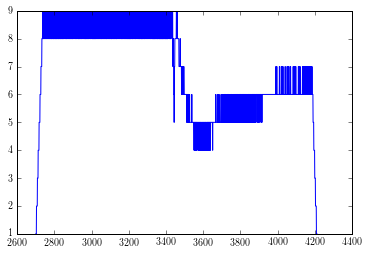

In [21]:
plt.plot(previously_tracked[0]._t, previously_tracked[0]._w)
plt.show()

AttributeError: 'list' object has no attribute 'shape'

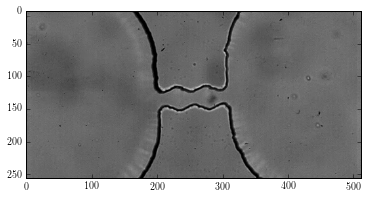

In [43]:
plt.imshow(template_image)
temp_image=template_image[:,:,:]
interval=10
nums=[int(i*1.*len(previously_tracked[0]._pixels)/interval) for i in range(interval)]

for i in nums[0:2]:
    temp_image=highlight_cluster_pixels(temp_image, previously_tracked[0]._pixels[i])
    
    
    
plt.imshow(temp_image)

plt.show()